# Twitter Classification

The first goal of this project is to predict whether a tweet will go viral using a K-Nearest Neighbor classifier, the second is to determine whether a tweet was sent from New York, London, or Paris using Naive Bayes classifiers. Therefore, in the first part we'll try to understand what influences tweet's virality most: tweet's length, number of links/hashtags, language or account info. In the second part we will investigate how language is used differently in the cities mentioned above.

Additional questions to tackle:
- Can the classifier automatically detect the difference between French and English? 
- Can it learn local phrases or slang? 
- Can one create tweets that trick the system?


### Investigation and Cleaning

Let's start by importing necessary tools, loading first part of data `random_tweets` in `all_tweets` variable and displaying some basic info about this dataset.

In [138]:
# Basic imports related to analysis
import pandas as pd
import numpy as np

# Imports related to visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Imports related to preprocessing
from sklearn.preprocessing import scale

# Imports related to ml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


In [38]:
# Display all columns
pd.set_option('display.max_columns', None)

# Read json file
all_tweets = pd.read_json("random_tweets.json", lines=True)
all_tweets.head(3)

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,withheld_in_countries
0,2018-07-31 13:34:40+00:00,1024287229525598210,1024287229525598208,RT @KWWLStormTrack7: We are more than a month ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 145388018, 'id_str': '145388018', 'name...",None,None,None,NaN,{'created_at': 'Mon Jul 30 16:49:41 +0000 2018...,False,3,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-07-31 13:34:40+00:00,1024287229512953856,1024287229512953856,@hail_ee23 Thanks love its just the feeling of...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.024128e+18,1.024128e+18,9.271857e+17,9.271857e+17,hail_ee23,"{'id': 2407992339, 'id_str': '2407992339', 'na...",None,None,"{'id': '26b41b13d49ea2bf', 'url': 'https://api...",NaN,NaN,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-07-31 13:34:40+00:00,1024287229504569344,1024287229504569344,RT @TransMediaWatch: Pink News has more on the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 901579698223931392, 'id_str': '90157969...",None,None,None,NaN,{'created_at': 'Tue Jul 31 11:03:32 +0000 2018...,False,5,0,False,False,en,0.0,NaN,NaN,NaN,NaN,NaN


That's a lot of columns. Let's check the dataset's metadata to find more. 

In [13]:
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11099 entries, 0 to 11098
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 11099 non-null  datetime64[ns, UTC]
 1   id                         11099 non-null  int64              
 2   id_str                     11099 non-null  int64              
 3   text                       11099 non-null  object             
 4   truncated                  11099 non-null  bool               
 5   entities                   11099 non-null  object             
 6   metadata                   11099 non-null  object             
 7   source                     11099 non-null  object             
 8   in_reply_to_status_id      1402 non-null   float64            
 9   in_reply_to_status_id_str  1402 non-null   float64            
 10  in_reply_to_user_id        1503 non-null   float64            
 11  in

Result: 
- There are a lot of empty fields in this dataset, some them marked as `NaN` and others as `None`, nevertheless both considered as missing values. 
- Some columns were auto-converted by `pandas` from strings to integers, though were meant to be kept as strings in `json`, as `id_str` for instance.  
- Apparently, some of the columns are dictionaries, for example, column `user`. So we might use some of the information found in these sub-dictionaries. 

In [49]:
all_tweets.loc[0]["user"]

{'id': 145388018,
 'id_str': '145388018',
 'name': 'Derek Wolkenhauer',
 'screen_name': 'derekw221',
 'location': 'Waterloo, Iowa',
 'description': '',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 215,
 'friends_count': 335,
 'listed_count': 2,
 'created_at': 'Tue May 18 21:30:10 +0000 2010',
 'favourites_count': 3419,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': False,
 'statuses_count': 4475,
 'lang': 'en',
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '022330',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme15/bg.png',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme15/bg.png',
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/995790590276243456/cgxRVviN_normal.jpg',
 'profile_image_url_https': 'https://pbs.twimg.com/profile

For example, we could fish out user's nick and location out of the `user` dictionary.

In [33]:
all_tweets.loc[0]['user']['screen_name']

'derekw221'

In [34]:
all_tweets.loc[0]['user']['location']

'Waterloo, Iowa'

### Defining Viral Tweets

A K-Nearest Neighbor classifier is a supervised machine learning algorithm, so we need to have a dataset with tagged labels to work with it. So to predict virality we first need to mark each tweet in this dataset as `viral` or `not viral`.

We will start by looking at statistics of retweets.

In [42]:
all_tweets.retweet_count.describe()

count     11099.000000
mean       2777.956392
std       12180.169923
min           0.000000
25%           0.000000
50%          13.000000
75%         428.500000
max      413719.000000
Name: retweet_count, dtype: float64

In [60]:
all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > all_tweets.retweet_count.median(), 1, 0)
all_tweets.is_viral.head()

0    0
1    0
2    0
3    1
4    0
Name: is_viral, dtype: int32

# Making Features

Now that we've created a label for every tweet in our dataset, we can begin thinking about which features might determine whether a tweet is viral. We can create new columns in our dataset to represent these features. 

Our fearues will be: 
- `tweet_length`; 
- `followers_count`; 
- `friends_count`; 
- `tweet_hashtags`;
- `tweet_links`;
- `tweet_words_count`;
- `words_avg_lenth`.

In [61]:
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
all_tweets.tweet_length.head()

0    140
1     77
2    140
3    140
4    140
Name: tweet_length, dtype: int64

In [72]:
all_tweets['followers_count'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
all_tweets.followers_count.head()

0     215
1     199
2     196
3    3313
4     125
Name: followers_count, dtype: int64

In [73]:
all_tweets['friends_count'] = all_tweets.apply(lambda tweet: tweet['user']['friends_count'], axis=1)
all_tweets.friends_count.head()

0     335
1     203
2     558
3    2272
4     273
Name: friends_count, dtype: int64

In [95]:
all_tweets['tweet_hashtags'] = all_tweets.apply(lambda tweet: tweet['text'].count('#'), axis=1)

How many tweets have more than 5 hashtags? 

In [98]:
len(all_tweets.tweet_hashtags[all_tweets.tweet_hashtags > 5])

35

In [111]:
all_tweets['tweet_links'] = all_tweets.apply(lambda tweet: tweet['text'].count('http'), axis=1)

How many tweets with more than one link we got?

In [108]:
len(all_tweets.tweet_links[all_tweets.tweet_links > 1])

176

In [109]:
all_tweets['tweet_words_count'] = all_tweets.apply(lambda tweet: len(tweet['text'].split()), axis=1)


In [114]:
all_tweets.tweet_words_count.describe()

count    11099.000000
mean        19.461753
std          5.680495
min          1.000000
25%         16.000000
50%         21.000000
75%         24.000000
max         41.000000
Name: tweet_words_count, dtype: float64

In [124]:
all_tweets['words_avg_lenth'] = all_tweets.apply(lambda tweet: np.mean([len(word) for word in tweet['text'].split()]), axis=1)
all_tweets.words_avg_lenth.head()


0    4.423077
1    4.200000
2    5.409091
3    4.875000
4    4.875000
Name: words_avg_lenth, dtype: float64

Let's create separate variables `features` and `classes`.

In [322]:
features = all_tweets[
    ['tweet_length', 
    'followers_count', 
    'friends_count', 
    'tweet_links', 
    'tweet_hashtags', 
    'tweet_words_count', 
    'words_avg_lenth']
    ]
classes = all_tweets.is_viral

### Normalizing The Data

Let's now normalise our features so their scales wouldn't be so drastically different and model would give them adequate rate of importance. We are going to use Z-score normalization from `scikit-learn`.

In [323]:
features_scaled = scale(features)

# Display first row
features_scaled[0]

array([ 0.6164054 , -0.02878298, -0.14483305, -0.78415588, -0.32045057,
        1.15105133, -0.63295806])

### Creating the Training Set and Test Set

To evaluate the effectiveness of our classifier, we now split `features_scaled` and `classes` into a training sets and testing sets using scikit-learn's `train_test_split` function.

In [331]:
# Split data into training and testing sets
train_features, test_features, train_classes, test_classes = train_test_split(
    features_scaled, 
    classes, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=3
    )

# Display first 5 rows
train_classes[:5]

8237    1
198     1
7877    0
5771    0
7258    1
Name: is_viral, dtype: int32

In [332]:
# Display first 5 rows
train_features[:5]

array([[ 0.6164054 , -0.02737219, -0.1083415 , -0.78415588, -0.32045057,
         0.62290454, -0.26795305],
       [ 0.6164054 , -0.02977649, -0.16118231, -0.78415588, -0.32045057,
         0.44685561, -0.21798353],
       [ 0.58049776, -0.02694497, -0.12900696,  1.11738358, -0.32045057,
        -0.08129118,  0.37086248],
       [ 0.6164054 , -0.02532058,  0.06888449,  1.11738358, -0.32045057,
        -1.66573155,  3.84443672],
       [-0.85580803, -0.02402901, -0.0683185 ,  1.11738358, -0.32045057,
        -0.7854869 ,  0.00874893]])

### Find best K value

Our next goal is to find the `k` nearest classified neighbours of the unclassified point using K-Nearest Neighbour Algorithm. 

The idea behind it is finding `k` number of known data-points that are most related from features perspective to the unknown data-point using distance formula, after what just put the unknown data-point in the same class ass the majority of known most related to it data-points already are. 

But before creating the best possible classifier we should find the best value for the parameter `n_neighbors` or `k`. To find it we'll try to run the classifier with a bunch of different values from 1 to 200 and choose the one with the highest accuracy level. 


In [333]:
scores=[]
for k in range(1, 200):
    # Instantiate model
    classifier = KNeighborsClassifier(n_neighbors=k)
    # Train the model
    classifier.fit(train_features, train_classes)
    # Get model's accuracy
    scores.append(classifier.score(test_features, test_classes))

# Get first 5 accuracy values
scores[:5]

[0.6833333333333333,
 0.6617117117117117,
 0.7103603603603603,
 0.7022522522522523,
 0.7243243243243244]

Let's get those values on the graph to see how the accuracy changes depending on `k`- value changes.

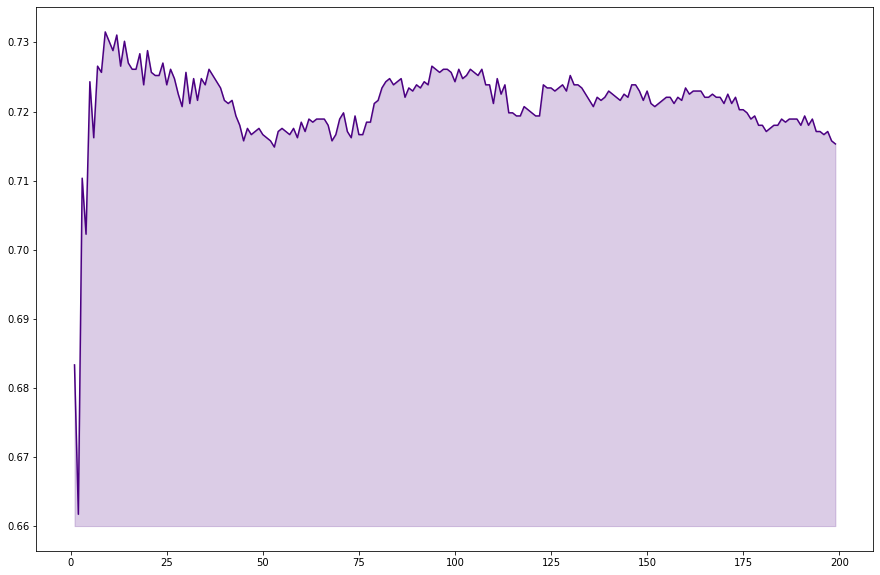

In [327]:
plt.figure(figsize=(15,10))
plt.plot(range(1, 200), scores, color='Indigo')
plt.fill_between(range(1, 200), 0.66, scores,
                 facecolor="Indigo", # The fill color
                 color='Indigo',     # The outline color
                 alpha=0.2) 

In [328]:
# Get maximum value of accuracy
np.max(scores)

0.7315315315315315

In [329]:
# Find k value that gets maximum accuracy
scores.index(np.max(scores)) + 1

9

In [330]:
# Instantiate model with best k
best_k_classifier = KNeighborsClassifier(n_neighbors=scores.index(np.max(scores)) + 1)
# Train the model
best_k_classifier.fit(train_features, train_classes)
# Get model's accuracy
print('Accuracy: ', best_k_classifier.score(test_features, test_classes).round(2) *100, '%')

Accuracy:  73.0 %


Result: We have trained our classifier using features that potentially could influence tweet's virality, after that we've performed intrinsic testing and got `73%` of accuracy, meaning that now if we get this classifier 10 random tweets it should determine at least 7 of them correctly (as viral or not).